<a href="https://colab.research.google.com/github/esmanursaracbasi/license_detection_and_recognition/blob/master/license_detection_and_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import json
import urllib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import time
from PIL import Image
import imutils

In [ ]:
!pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.1-py2.py3-none-any.whl size=13374 sha256=35d54f6fd070b4391348e6203b822faa5be98a741028988c4bab831d304df0c8
  Stored in directory: /root/.cache/pip/wheels/01/84/d2/10729e740ad8f5c5d3b02d10c7f15afeaa390f7723bd59dbd7
Successfully built pytesseract


In [ ]:
import pytesseract

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam


Using TensorFlow backend.


In [ ]:
#selecting "train_data.csv" 
from google.colab import files
uploaded = files.upload()

Saving train_data.csv to train_data.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['train_data.csv']))

In [ ]:
df["image_name"] = df["image_name"] + ".jpeg"

In [ ]:
df.head()
#this dataset gives imageid , and coordinates of the licence plate

,image_name,image_width,image_height,top_x,top_y,bottom_x,bottom_y
0,licensed_car0.jpeg,806,466,0.722084,0.587983,0.868486,0.688841
1,licensed_car1.jpeg,494,449,0.161943,0.850780,0.582996,1.000000
2,licensed_car2.jpeg,500,314,0.082000,0.697452,0.230000,0.828025
3,licensed_car3.jpeg,500,469,0.434000,0.667377,0.718000,0.765458
4,licensed_car4.jpeg,1001,563,0.208791,0.390764,0.865135,0.984014


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving licensed_car0.jpeg to licensed_car0.jpeg
Saving licensed_car1.jpeg to licensed_car1.jpeg
Saving licensed_car2.jpeg to licensed_car2.jpeg
Saving licensed_car3.jpeg to licensed_car3.jpeg
Saving licensed_car4.jpeg to licensed_car4.jpeg
Saving licensed_car5.jpeg to licensed_car5.jpeg
Saving licensed_car6.jpeg to licensed_car6.jpeg
Saving licensed_car7.jpeg to licensed_car7.jpeg
Saving licensed_car8.jpeg to licensed_car8.jpeg
Saving licensed_car10.jpeg to licensed_car10.jpeg
Saving licensed_car11.jpeg to licensed_car11.jpeg
Saving licensed_car12.jpeg to licensed_car12.jpeg
Saving licensed_car13.jpeg to licensed_car13.jpeg
Saving licensed_car15.jpeg to licensed_car15.jpeg
Saving licensed_car16.jpeg to licensed_car16.jpeg
Saving licensed_car17.jpeg to licensed_car17.jpeg
Saving licensed_car18.jpeg to licensed_car18.jpeg
Saving licensed_car20.jpeg to licensed_car20.jpeg
Saving licensed_car22.jpeg to licensed_car22.jpeg
Saving licensed_car23.jpeg to licensed_car23.jpeg
Saving licensed_ca

In [ ]:
WIDTH = 224
HEIGHT = 224
CHANNEL = 3

def show_img(index):
    image = cv2.imread(df["image_name"].iloc[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(WIDTH, HEIGHT))

    tx = int(df["top_x"].iloc[index] * WIDTH)
    ty = int(df["top_y"].iloc[index] * HEIGHT)
    bx = int(df["bottom_x"].iloc[index] * WIDTH)
    by = int(df["bottom_y"].iloc[index] * HEIGHT)

    image = cv2.rectangle(image, (tx, ty), (bx, by), (0, 0, 255), 1)
    plt.imshow(image)
    plt.show()

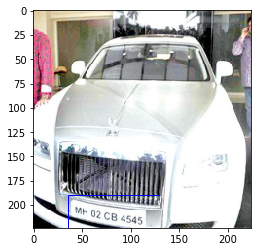

In [ ]:
show_img(1)

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_dataframe( # flow_from_dataframe takes df and directory and generates batches of augmented data.
    df,
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="raw", 
    subset="training")

validation_generator = datagen.flow_from_dataframe(
    df, 
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="raw",
    subset="validation")

Found 205 validated image filenames.
Found 22 validated image filenames.


In [ ]:
from keras import regularizers

In [ ]:
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(HEIGHT, WIDTH, CHANNEL)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="relu"))

model.layers[-6].trainable = False

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 260       
Total params: 17,938,756
Trainable params: 3,224,068
Non-trainable params: 14,714,688
__________________________________

In [ ]:
STEP_SIZE_TRAIN = int(np.ceil(train_generator.n / train_generator.batch_size))
STEP_SIZE_VAL = int(np.ceil(validation_generator.n / validation_generator.batch_size))

print("Train step size:", STEP_SIZE_TRAIN)
print("Validation step size:", STEP_SIZE_VAL)

train_generator.reset()
validation_generator.reset()

Train step size: 7
Validation step size: 1


In [ ]:
adam = Adam(lr=0.0005)
model.compile(optimizer=adam, loss="mse")

In [ ]:
history = model.fit_generator(train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VAL,
    epochs=30)

Epoch 1/30
7/7 [==============================] - 118s 17s/step - loss: 0.2565 - val_loss: 0.1373
Epoch 2/30
7/7 [==============================] - 114s 16s/step - loss: 0.1095 - val_loss: 0.1091
Epoch 3/30
7/7 [==============================] - 115s 16s/step - loss: 0.0875 - val_loss: 0.1040
Epoch 4/30
7/7 [==============================] - 114s 16s/step - loss: 0.0756 - val_loss: 0.0915
Epoch 5/30
7/7 [==============================] - 114s 16s/step - loss: 0.0706 - val_loss: 0.0896
Epoch 6/30
7/7 [==============================] - 114s 16s/step - loss: 0.0666 - val_loss: 0.0850
Epoch 7/30
7/7 [==============================] - 115s 16s/step - loss: 0.0642 - val_loss: 0.0837
Epoch 8/30
7/7 [==============================] - 114s 16s/step - loss: 0.0632 - val_loss: 0.0846
Epoch 9/30
5/7 [====================>.........] - ETA: 28s - loss: 0.0607

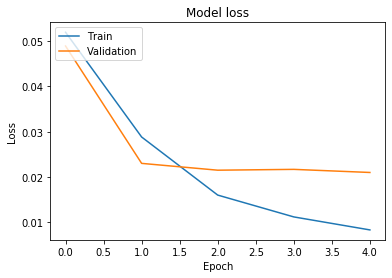

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.evaluate_generator(validation_generator, steps=STEP_SIZE_VAL)

0.021031279116868973

In [ ]:
#selecting "test_data.csv" 
from google.colab import files
uploaded = files.upload()

Saving test_data.csv to test_data (2).csv


In [ ]:
test_df = pd.read_csv(io.BytesIO(uploaded['test_data.csv']))

In [ ]:
test_df.head(20)

In [ ]:
#selecting "indian_license_plates_mine.csv" 
from google.colab import files
uploaded = files.upload()

Saving indian_license_plates_mine.csv to indian_license_plates_mine (1).csv


In [ ]:
indian_df = pd.read_csv(io.BytesIO(uploaded['indian_license_plates_mine.csv']))
indian_df["image_name"] = indian_df["image_name"] + ".jpeg"
indian_df.head()

,image_name,image_width,image_height,top_x,top_y,bottom_x,bottom_y
0,licensed_car0.jpeg,806,466,0.722084,0.587983,0.868486,0.688841
1,licensed_car1.jpeg,494,449,0.161943,0.850780,0.582996,1.000000
2,licensed_car2.jpeg,500,314,0.082000,0.697452,0.230000,0.828025
3,licensed_car3.jpeg,500,469,0.434000,0.667377,0.718000,0.765458
4,licensed_car4.jpeg,1001,563,0.208791,0.390764,0.865135,0.984014


In [ ]:
#selecting "test_data" 
from google.colab import files
uploaded = files.upload()

Saving licensed_car9.jpeg to licensed_car9 (1).jpeg
Saving licensed_car14.jpeg to licensed_car14 (1).jpeg
Saving licensed_car16.jpeg to licensed_car16 (1).jpeg
Saving licensed_car19.jpeg to licensed_car19 (1).jpeg
Saving licensed_car21.jpeg to licensed_car21 (1).jpeg
Saving licensed_car30.jpeg to licensed_car30 (1).jpeg
Saving licensed_car31.jpeg to licensed_car31 (1).jpeg
Saving licensed_car37.jpeg to licensed_car37 (1).jpeg
Saving licensed_car50.jpeg to licensed_car50 (1).jpeg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


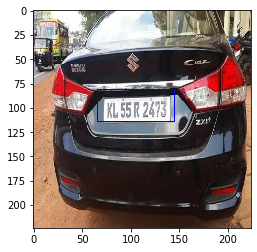

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


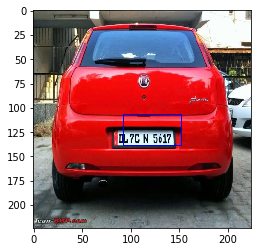

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


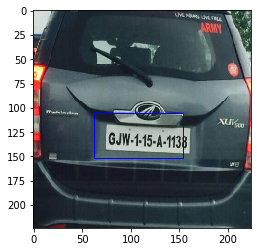

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


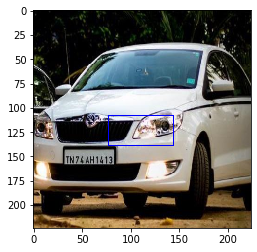

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


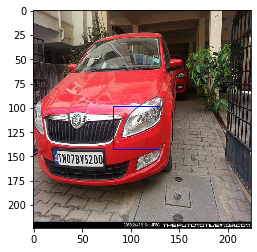

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


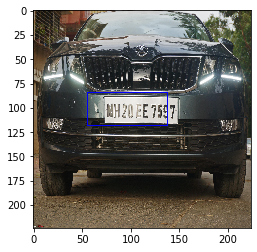

In [ ]:
random_test_samples = np.array([9,14,19,16,30,31])

for idx, row in indian_df.iloc[random_test_samples].iterrows():    
    img = cv2.resize(cv2.imread( row[0]) / 255.0, dsize=(WIDTH, HEIGHT))
    y_hat = model.predict(img.reshape(1, WIDTH, HEIGHT, 3)).reshape(-1) * WIDTH
    
    xt, yt = y_hat[0], y_hat[1]
    xb, yb = y_hat[2], y_hat[3]
    
    img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(img, (xt, yt), (xb, yb), (0, 0, 255), 1)
    plt.imshow(image)
    plt.show()

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
! apt install tesseract-ocr
! apt install libtesseract-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 7 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,089 kB/s)
Selecting previously unselecte

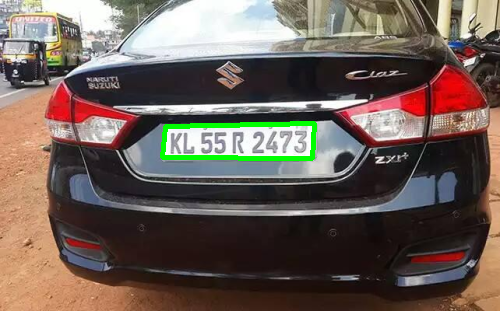

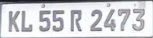

Number is: KL55R 2473


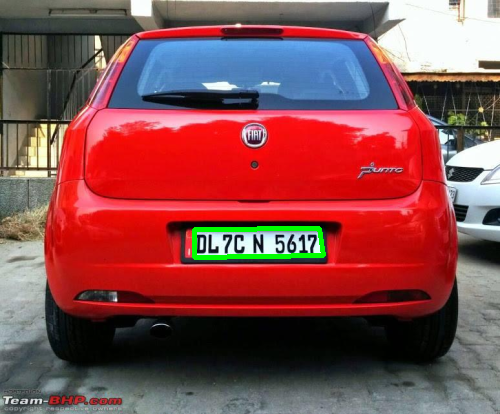

Number is: DL7C N 5617


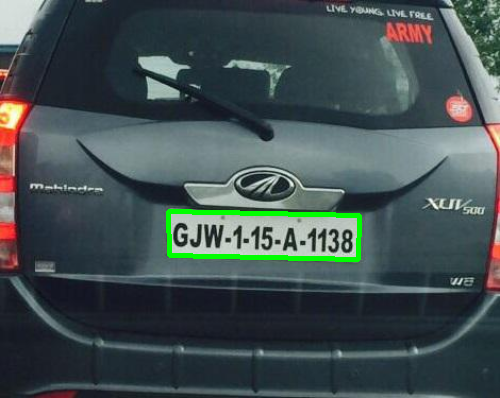

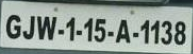

Number is: GJW-1-15-A-1138


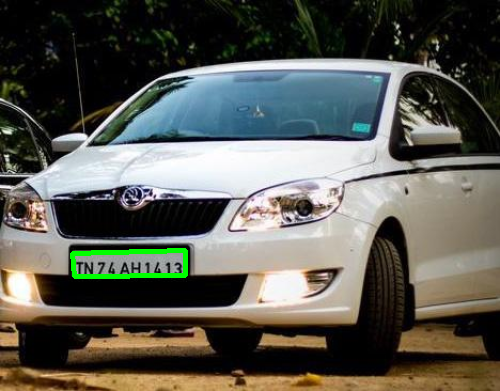

Number is: '™N746AH1413.


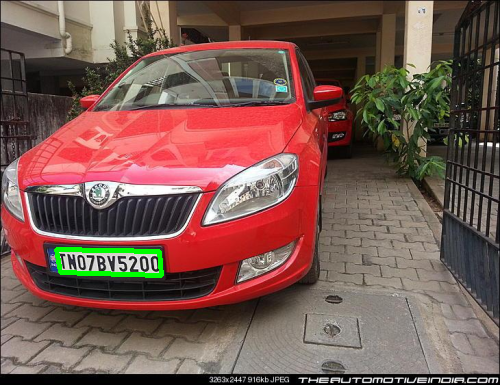

Number is: \WO7BY5200)


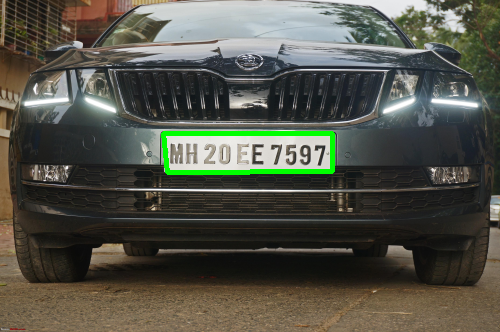

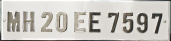

Number is: MH20EE75

97,


In [ ]:
test_samples = ["licensed_car9.jpeg","licensed_car14.jpeg","licensed_car19.jpeg","licensed_car16.jpeg","licensed_car30.jpeg","licensed_car31.jpeg"]
for i in test_samples:    
    img = cv2.imread(i,cv2.IMREAD_COLOR)
    img = imutils.resize(img, width=500 )
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert to grey scale
    gray = cv2.bilateralFilter(gray, 11, 17, 17) #Blur to reduce noise
    threshGauss = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 51, 27)
    edged = cv2.Canny(gray, 170, 200) #Perform Edge detection
    #edged = cv2.Canny(gray, 170, 200)
    #cv2_imshow(edged)
    #cv2.waitKey(0)
    # find contours from the edged image and keep only the largest
    # ones, and initialize our screen contour
    cnts= cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:10]
    img1=img.copy()
    cv2.drawContours(img1,cnts,-1,(0,255,0),3)
    #cv2_imshow(img1)
    #cv2.waitKey(0)

    #sorts contours based on minimum area 30 and ignores the ones below that
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:30]
    screenCnt = None #will store the number plate contour
    img2 = img.copy()
    cv2.drawContours(img2,cnts,-1,(0,255,0),3) 
    
    #cv2_imshow(img2) #top 30 contours
    #cv2.waitKey(0)
    count=0
    idx=7
    # loop over contours
    for c in cnts:
      # approximate the contour
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.018 * peri, True)
            if len(approx) == 4: #chooses contours with 4 corners
                    screenCnt = approx
                    x,y,w,h = cv2.boundingRect(c) #finds co-ordinates of the plate
                    new_img=img[y:y+h,x:x+w]
                    cv2.imwrite('./'+str(idx)+'.png',new_img) #stores the new image
                    idx+=1
                    break
                
    #draws the selected contour on original image        
    cv2.drawContours(img, [screenCnt], -1, (0, 255, 0), 3)
    cv2_imshow(img)
    cv2.waitKey(0)
    Cropped_loc='./7.png' #the filename of cropped image
    cv2_imshow(cv2.imread(Cropped_loc)) 
    config = '-l eng --oem 3 --psm 12'
    config2='-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    config3= '-l eng --oem 1 --psm 3'
    text=pytesseract.image_to_string(Cropped_loc,config=config) #converts image characters to string
    print("Number is:" ,text)
    cv2.waitKey(0)
    cv2.destroyAllWindows() 
